## Прогнозирование вероятности невыполнения контракта поставщиком 


ДАННЫЕ: Московский кредитный банк (МКБ) 

ЗАДАЧА: построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска. В качестве предикторов для моделирования используются анкетные данные клиента и его финансовые показатели.

Банковская гарантия — соглашение, по которому банк обязан выплатить долг клиента, если тот не выполнил своих обязательств. Выдача гарантий банком происходит после одобрения клиентской заявки.

In [2]:
import warnings
warnings.simplefilter(action='error', category=FutureWarning)

import numpy as np
from numpy import inf
import pandas as pd

import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

**Трансформация данных и разделение на два датасета:**
 - контракты с юридическими лицами (data_1);
 - контракты с индивидуальными предпринимателями (data_2).

In [36]:
def replacing_outliers(column):
    '''Функция для замены выбросов средним значением
    с помощью правила трех сигм:'''
    
    mean = column.mean()
    std = column.std()
    outliers = (column - mean).abs() > 3*std
    column[outliers] = (column[~(outliers)]).mean()
    return column


def data_transformation(initial_data, TARGET = None):
    """Функция для трансформации данных и разделения на два датасета"""
    
    pd.set_option('chained',None)
    data = initial_data.copy()
    
    # Показатели финансового положения и эффективности деятельности организации:
    
    fin = ['F1100', 'F1150', 'F1150_LAG1', 'F1200', 
           'F1230', 'F1230_LAG1', 'F1240', 'F1250',
           'F1300', 'F1400', 'F1500', 'F1520', 'F1520_LAG1', 
           'F1530', 'F1600', 'F2110', 'F2110_LAG1', 'F2300', 'F2300_LAG1',
           'F2400', 'F2400_LAG1']
    data.loc[:, fin] = data[fin].fillna(0)
    
    # Собственный капитал, млн. руб.
    data.loc[:, 'Fund'] = (data['F1300'] + data['F1530'])\
                          .apply(lambda x : round(x/1000000, 2))
    
    # Коэффициент автономии 
    data.loc[:, 'Autonomy'] = (data['F1300'] + data['F1530'])\
                            / (data['F1300'] + data['F1400'] + data['F1500'])
    
    # Коэффициент текущей ликвидности 
    data.loc[:, 'Сurrent_Ratio'] = (data['F1200'] - data['F1230'])\
                                      / data['F1500']
    
    # Динамика рентабельности продаж по прибыли до налогооблажения с предыдущего периода, % (return on sales)
    data.loc[:, 'Dynamics_ROS'] = ((data['F2300'] / data['F2110'])\
                                    - (data['F2300_LAG1'] / data['F2110_LAG1']))* 100
    
    # Динамика основных средств с предыдущего периода, %
    data.loc[:, 'Dynamics_OS'] = (((data['F1150'] - data['F1150_LAG1'])\
                                / data['F1150_LAG1']) * 100)
    
    # Динамика дебиторской задолженности с предыдущего периода, %  
    data.loc[:, 'Dynamics_D'] = ((data['F1230'] - data['F1230_LAG1'])\
                                / data['F1230_LAG1']) * 100
    
    # Динамика кредиторской задолженности с предыдущего периода, %
    data.loc[:, 'Dynamics_C'] = ((data['F1520'] - data['F1520_LAG1'])\
                                / data['F1520_LAG1']) * 100
    
    financial_columns = ['Autonomy', 'Dynamics_OS',
                        'Сurrent_Ratio', 'Dynamics_ROS',
                        'Dynamics_D','Dynamics_C', 'F1600',
                        'F1150', 'F1230', 'F1520',
                        'F2110', 'F2300', 'F2400']
    data.loc[:, financial_columns] = data[financial_columns].fillna(0)\
                                .applymap(lambda x: 100 if x == inf else (-100 if x == -inf else round(x, 2)))\
                                .apply(replacing_outliers)
    
    # Количество исков и контрактов:
    counts = ['PLAINTIFF_CASESNUMBER_YEAR', 'PLAINTIFF_CASESNUMBER_EVER',
              'DEFENDANT_CASESNUMBER_YEAR', 'DEFENDANT_CASESNUMBER_EVER'] 
    # Суммы по искам и контрактам, млн. руб.
    amounts = ['PLAINTIFF_SUM_YEAR', 'PLAINTIFF_SUM_EVER',
               'DEFENDANT_SUM_YEAR', 'DEFENDANT_SUM_EVER',
               'SUM_233_YEAR', 'SUM_233_EVER',
               'SUM_95_YEAR', 'SUM_95_EVER']
    
    data.loc[:, counts] = data[counts].fillna(0).astype(int)
    data.loc[:, amounts] = data[amounts].fillna(0)\
                          .apply(lambda x : round(x/1000000, 2))\
                          .apply(replacing_outliers)
    
    # Количество компаний с аналогичным  руководителem (выбор максимального значения)
    managers = ['MANAGERCOUNTINCOUNTRY', 
                'MANAGERCOUNTINREGION', 'MANAGERINNCOUNT']
    data.loc[:, 'MANAGERCOUNT'] = data[managers].max(axis=1)
    
    # Преобразование дат
    dates = ['SIGN_DATE', 'DATEFIRSTREG']
    data.loc[:, dates] = data[dates].apply(lambda x: x.fillna('0'))\
                                     .applymap(lambda x: x.split(':')[0])
    data.loc[:, dates] = data[dates]\
                        .applymap(lambda x: pd.to_datetime(x, errors='coerce')) 
    # Возраст компании (лет)
    data.loc[:, 'COMPANY_AGE'] = ((data['SIGN_DATE'] - data['DATEFIRSTREG'])\
                              /np.timedelta64(1, 'Y'))\
                              .apply(lambda x: int(x) if x >=1 else (0 if x<1 else np.nan))
    
    # Дата регистрации в ФНС (месяц, год) для включения в категориальные данные
    data.loc[:, 'Taxreg_Regdate'] = data['TAXREG_REGDATE'].fillna('0')\
                                   .apply(lambda x: str(x.split(':')[0])[2:9])
    # Количественные данные
    count_columns = ['COUNTCOOWNERROSSTAT', 'MANAGERCOUNT', 'TELEPHONECOUNT']
    data.loc[:, count_columns] = data[count_columns].fillna(0).astype(int)

    # Категориальные данные
    category_columns = ['WORKERSRANGE', 'OKOGU_GROUP', 'OKFS_GROUP', 'OKOPF_GROUP', 
                        'OKATO_FED', 'OKTMO_CODE', 'OKVED_CODE', 
                        'Taxreg_Regdate', 'COMPANY_AGE',
                        'TAXREGPAY_REGDATE', 'AGE', 'SEX_NAME'] 
    data.loc[:, category_columns] = data[category_columns]\
                                  .astype('category').apply(lambda x: x.cat.codes)
    
    # выделение данных Юридических Лиц (data_1) 
    columns_1 = ['id_contract', 'id_client', 'Fund']\
                + financial_columns + counts[1:2] + amounts[1:8] \
                + count_columns + category_columns[0:9]
    
    data_1 = data[data['IP_flag'] == 0][columns_1]
    
    # выделение данных Индивидуальных Предпринимателей (data_2) 
    columns_2 = ['id_contract', 'id_client'] + counts[0:4]\
                  + amounts[0:4] + category_columns[4:12]
    
    data_2 = data[data['IP_flag'] == 1][columns_2]
    
    if TARGET is not None:
        data_1 = data[data['IP_flag'] == 0][columns_1 + ['TARGET']]
        data_2 = data[data['IP_flag'] == 1][columns_2 + ['TARGET']]
    
    return data_1, data_2

Создание алгоритма прогнозирования целевой переменной для данных по контрактам юридических лиц:

In [37]:
def boosting_JL(x_train, x_test, y_train, y_test=None):
    """Алгоритм XGBoost с использованием объектов DMatrix
    для данных по контрактам юридических лиц"""
    
    #Веса для экземпляров классов
    weights = np.zeros(len(y_train))
    weights[y_train == 0] = 1
    weights[y_train == 1] = 2

    dtrain = xgb.DMatrix(x_train, y_train)  #, weight = weights)
    dtest = xgb.DMatrix(x_test, y_test)
    
    ratio = np.sum(dtrain.get_label() == 0) / np.sum(dtrain.get_label() == 1)

    params = {'objective': 'binary:logistic', 
              'scale_pos_weight': ratio,
              'gamma': 2,
              'reg_lambda': 2, 
              'max_depth': 7, 
              'min_child_weight': 7,
              'learning_rate': 0.01,
              'colsample_bytree': 0.8,
              'subsample': 0.6}
    
    algorithm = xgb.train(params, dtrain, num_boost_round = 650)

    #вероятности принадлежности объектов тестовой выборки к классам
    pred = algorithm.predict(dtest)
    return pred, algorithm

Создание алгоритма прогнозирования целевой переменной для данных по контрактам индивидуальных предпринимателей:

In [5]:
def boosting_IP(x_train, x_test, y_train, y_test=None):
    """Алгоритм XGBoost с использованием объектов DMatrix
    для данных по контрактам индивидуальных предпринимателей"""
    
    dtrain = xgb.DMatrix(x_train, y_train)
    dtest = xgb.DMatrix(x_test, y_test)

    ratio = np.sum(dtrain.get_label() == 0) / np.sum(dtrain.get_label() == 1)

    params = {'objective': 'binary:logistic', 
              'scale_pos_weight': ratio,
              'gamma': 3,
              'reg_lambda': 2, 
              'max_depth': 7,
              'colsample_bytree': 0.9,
              'subsample': 1,
              'verbosity': 0,
              'eta': 0.03}
    
    algorithm = xgb.train(params, dtrain, num_boost_round = 1000)

    #вероятности принадлежности объектов тестовой выборки к классам
    pred = algorithm.predict(dtest)
    return pred, algorithm

In [38]:
def prediction_model(train_data, data_to_prediction, target_test=None):
    
    #Tрансформация тренировочных данных и разбиениe на два датасета
    data_JL_train, data_IP_train = data_transformation(train_data, TARGET = 1)
    
    #Tрансформация тестовых данных и разбиениe на два датасета
    data_JL_test, data_IP_test = data_transformation(data_to_prediction, TARGET = None)
    
    #Данные для модели ЮР 
    x_train_JL = data_JL_train.drop(['id_contract', 'TARGET'],
                                      axis = 'columns')
    x_test_JL = data_JL_test.drop(['id_contract'],
                                      axis = 'columns')
    y_train_JL = data_JL_train.TARGET
    
    #Данные для модели ИП 
    x_train_IP = data_IP_train.drop(['id_contract', 'TARGET'],
                                      axis = 'columns')
    x_test_IP = data_IP_test.drop(['id_contract'],
                                      axis = 'columns')
    y_train_IP = data_IP_train.TARGET
    
    #Модель бустинга и прогноз ЮР
    Predictions_JL, Model_JL = boosting_JL(x_train_JL, x_test_JL, y_train_JL, y_test=None)
    Predictions_JL_df = pd.DataFrame({'id_contract': data_JL_test.id_contract,
                                      'TARGET': list(map(float, Predictions_JL))})
    
    #Модель бустинга и прогноз ИП
    Predictions_IP, Model_IP = boosting_IP(x_train_IP, x_test_IP, y_train_IP, y_test=None)
    Predictions_IP_df = pd.DataFrame({'id_contract': data_IP_test.id_contract,
                                      'TARGET': list(map(float, Predictions_IP))})
    
    #Объединенный прогноз ЮР и ИП
    Predictions = pd.merge(Predictions_JL_df, Predictions_IP_df, how='outer').sort_values('id_contract')
    
    return Predictions, Model_JL, Model_IP

In [7]:
mkb_train = pd.read_csv('train_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')
mkb_test = pd.read_csv('test_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')

In [45]:
Predictions, Model_JL, Model_IP = prediction_model(mkb_train, mkb_test, target_test=None)

Файл для отправки:

In [46]:
Predictions.to_csv('submit_file.csv', encoding='utf-8', sep=';', index=False)

In [16]:
prob = pd.read_csv('submit_file.csv', encoding='cp1251', sep=';')
prob

,id_contract,TARGET
0,17892,0.025711
1,17893,0.540452
2,17894,0.403557
3,17895,0.635228
4,17896,0.754429
...,...,...
7325,25217,0.906938
7326,25218,0.345696
7327,25219,0.590846
7328,25220,0.571081


Результат на https://dsbattle.com/hackathons/mkb/:

In [47]:
0.841

0.84

Testing:

In [39]:
d1_1 = mkb_train.loc[0:14312, :]
d1_2 = mkb_train.loc[14313:17891, :]

In [42]:
d1_2 = mkb_train.loc[0:3312, :]
d1_1 = mkb_train.loc[3313:17891, :]

In [43]:
Predictions, Model_JL, Model_IP = prediction_model(d1_1, d1_2, target_test=None)

In [44]:
pred = Predictions.TARGET
y_test = d1_2.TARGET

print('ROC/AUC Score: %.4f' % roc_auc_score(y_test, pred))

ROC/AUC Score: 0.9270


**Важность признаков в алгоритмах:**

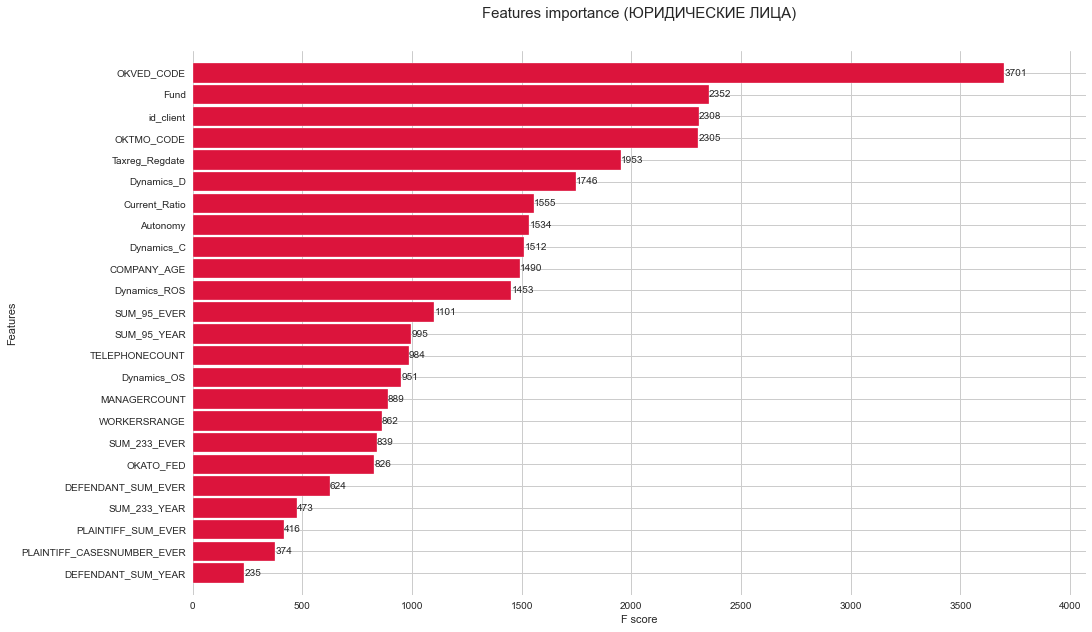

In [71]:
#plt.style.use('seaborn')
#sns.set_style("whitegrid")

xgb.plot_importance(Model_JL, height=0.9, color = 'crimson') 
plt.title('Features importance (ЮРИДИЧЕСКИЕ ЛИЦА)', y=1.05, size=15)
plt.rcParams["figure.figsize"] = (16,12)
plt.show()


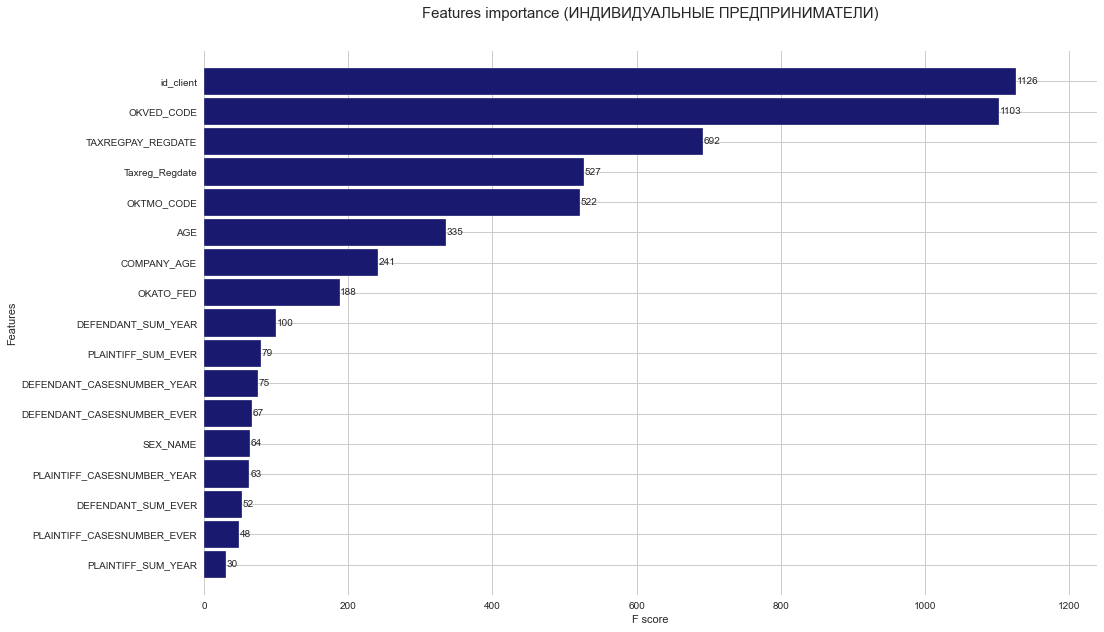

In [65]:
xgb.plot_importance(Model_IP, height=0.9, color = 'midnightblue') 
plt.title('Features importance (ИНДИВИДУАЛЬНЫЕ ПРЕДПРИНИМАТЕЛИ)', y=1.05, size=15)
plt.rcParams["figure.figsize"] = (10,4)
plt.show()